# 1. Import Libraries

In [1]:
#Import library yang dibutuhkan
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import skops.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import NearMiss
RANDOM_STATE = 42

## 1.1. Import Data

In [2]:
#Baca dataset
df = pd.read_csv('./MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')
df.rename(columns={' Label': 'Label'}, inplace=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [3]:
#Menggabungkan DoS
df['Label'] = df['Label'].replace({
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS'
})

## 1.2 Dataset Features

In [4]:
#Features pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             692703 non-null  int64  
 1    Flow Duration                692703 non-null  int64  
 2    Total Fwd Packets            692703 non-null  int64  
 3    Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets   692703 non-null  int64  
 5    Total Length of Bwd Packets  692703 non-null  int64  
 6    Fwd Packet Length Max        692703 non-null  int64  
 7    Fwd Packet Length Min        692703 non-null  int64  
 8    Fwd Packet Length Mean       692703 non-null  float64
 9    Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max         692703 non-null  int64  
 11   Bwd Packet Length Min        692703 non-null  int64  
 12   Bwd Packet Length Mean       692703 non-nul

## 1.3 Dataset Distribution

In [5]:
df['Label'].value_counts()

Label
BENIGN        440031
DoS           252661
Heartbleed        11
Name: count, dtype: int64

# 2. Data Preprocessing

## 2.1 Dealing with missing values

In [6]:
df[df.isnull().any(axis=1)]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
5106,80,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5833,49578,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8381,59597,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8552,41699,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
14762,43832,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602009,50834,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
629492,45113,0,1,1,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
653553,48698,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
671012,22567,0,2,0,0,0,0,0,0.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
#Hapus null value
df.dropna(inplace=True)

## 2.2 Dealing with infinite values

In [8]:
#Hapus infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

## 2.3 Dealing with duplicate columns

In [9]:
df[' Fwd Header Length'].equals(df[' Fwd Header Length.1'])

True

In [10]:
#Hapus kolom duplikat
df.drop(columns=' Fwd Header Length.1', inplace=True)

## 2.4 Remove unused data

In [11]:
# Hapus heartbleed
df = df[df.Label != 'Heartbleed'].copy(deep=True)

# 3. Feature Engineering

## 3.1 Split dataset into train and test set

In [12]:
y= df['Label']
X = df.loc[:, df.columns != "Label"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [14]:
y_train.value_counts()

Label
BENIGN    307778
DoS       176198
Name: count, dtype: int64

In [15]:
y_test.value_counts()

Label
BENIGN    131905
DoS        75514
Name: count, dtype: int64

## 3.2 Dealing with data imbalance

In [16]:
nm = NearMiss(sampling_strategy='all',n_jobs=-1)

In [17]:
X_train_resampled, y_train_resampled =nm.fit_resample(X_train, y_train)

In [18]:
y_train_resampled.value_counts()

Label
BENIGN    176198
DoS       176198
Name: count, dtype: int64

In [19]:
X_train_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352396 entries, 0 to 352395
Data columns (total 77 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             352396 non-null  int64  
 1    Flow Duration                352396 non-null  int64  
 2    Total Fwd Packets            352396 non-null  int64  
 3    Total Backward Packets       352396 non-null  int64  
 4   Total Length of Fwd Packets   352396 non-null  int64  
 5    Total Length of Bwd Packets  352396 non-null  int64  
 6    Fwd Packet Length Max        352396 non-null  int64  
 7    Fwd Packet Length Min        352396 non-null  int64  
 8    Fwd Packet Length Mean       352396 non-null  float64
 9    Fwd Packet Length Std        352396 non-null  float64
 10  Bwd Packet Length Max         352396 non-null  int64  
 11   Bwd Packet Length Min        352396 non-null  int64  
 12   Bwd Packet Length Mean       352396 non-nul

## 3.3 Bagging Decision Tree

In [20]:
bagging_dt = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), random_state=RANDOM_STATE,n_jobs=-1).fit(X_train_resampled, y_train_resampled)
y_pred = bagging_dt.predict(X_test)

In [21]:
#Evaluation
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

      BENIGN     0.9999    0.9676    0.9835    131905
         DoS     0.9465    0.9999    0.9725     75514

    accuracy                         0.9794    207419
   macro avg     0.9732    0.9838    0.9780    207419
weighted avg     0.9805    0.9794    0.9795    207419



## 3.4 Confusion Matrix

In [22]:
cm = confusion_matrix(y_test, y_pred)

In [23]:
cm_df = pd.DataFrame(cm,index = [f'{cls}' for cls in bagging_dt.classes_],columns=[f'{cls}' for cls in bagging_dt.classes_])

In [24]:
cm_df

,BENIGN,DoS
BENIGN,127634,4271
DoS,7,75507


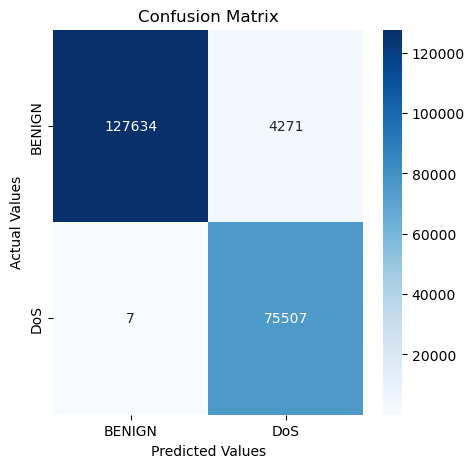

In [25]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, cmap='Blues',fmt="g")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

## 4. Dump model for use

In [26]:
sio.dump(bagging_dt,"ml-ids_model.skops")